In [1]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
jp_sales_df = pd.read_csv('data/Japan/Japan_console_weekly_sales.csv')
jp_gdp_df = pd.read_csv('data/Japan/Japan_GDP.csv', delimiter=';')
jp_ir_df = pd.read_csv('data/Japan/Japan_IR.csv', delimiter=';')
jp_unemployment_df = pd.read_csv('data/Japan/Japan_Unemployment.csv', delimiter=';')

jp_sales_df['week'] = pd.to_datetime(jp_sales_df['week'])
jp_sales_df['year'] = jp_sales_df['week'].dt.year

annual_sales = jp_sales_df.groupby('year')['sales'].sum().reset_index()
annual_sales['millions'] = annual_sales['sales'] / 1_000_000

jp_gdp_df['GDP'] = jp_gdp_df['GDP'] / 1_000_000_000_000

jp_merged_df = pd.merge(annual_sales, jp_gdp_df, on='year', how='inner')
jp_merged_df = pd.merge(jp_merged_df, jp_ir_df, on='year', how='inner')
jp_merged_df = pd.merge(jp_merged_df, jp_unemployment_df, on='year', how='inner')

jp_merged_df


,year,sales,millions,GDP,inflation_rate,unemployment
0,2004,1557436,1.557436,4.893116,-0.01,4.73
1,2005,6838566,6.838566,4.831467,-0.28,4.45
2,2006,11891162,11.891162,4.601663,0.25,4.19
3,2007,15382788,15.382788,4.579751,0.06,3.89
4,2008,11830491,11.830491,5.106679,1.38,4.00
5,2009,10405854,10.405854,5.289493,-1.35,5.07
6,2010,9489078,9.489078,5.759072,-0.73,5.10
7,2011,10305503,10.305503,6.233147,-0.27,4.55
8,2012,9528430,9.528430,6.272363,-0.04,4.36
9,2013,8360746,8.360746,5.212328,0.34,4.04


<Axes: xlabel='year'>

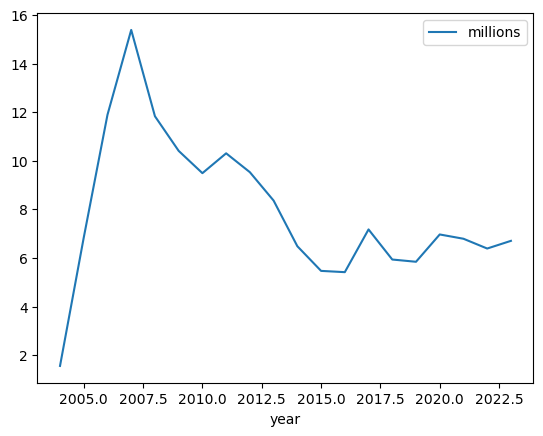

In [4]:
jp_merged_df.plot(kind='line', x='year', y='millions')

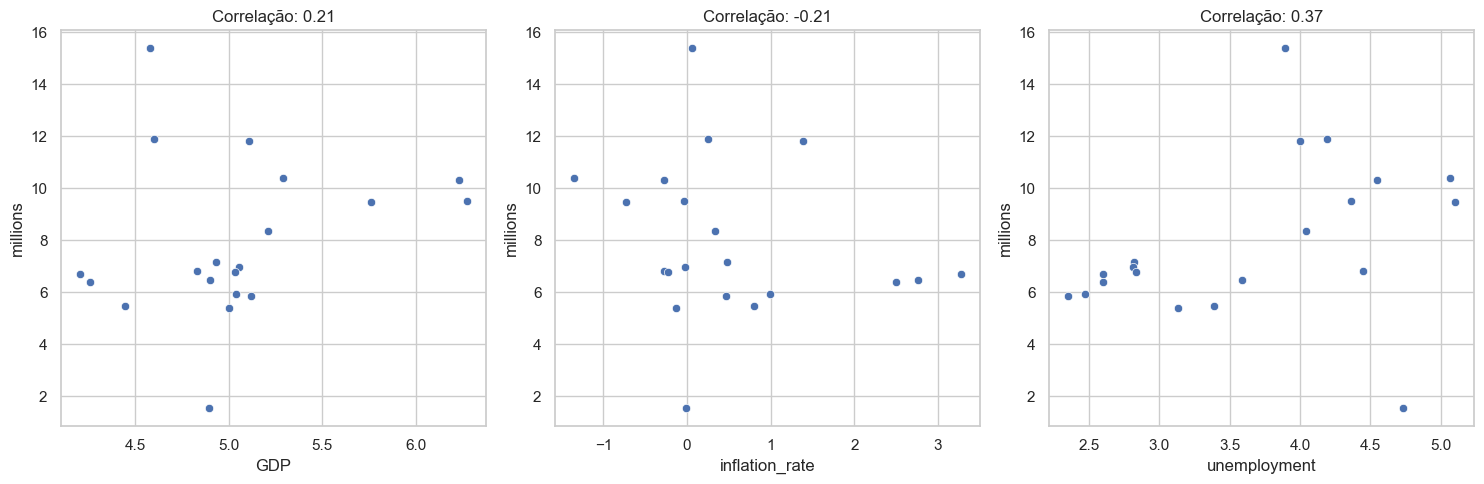

In [12]:
correlation_matrix = merged_df[['millions', 'GDP', 'inflation_rate', 'unemployment']].corr()
correlation_millions = correlation_matrix.loc['millions', ['GDP', 'inflation_rate', 'unemployment']]

plt.figure(figsize=(15, 5))

# millions vs GDP
plt.subplot(1, 3, 1)
sns.scatterplot(data=merged_df, x='GDP', y='millions')
plt.title(f"Correlação: {correlation_millions['GDP']:.2f}")

# millions vs inflation_rate
plt.subplot(1, 3, 2)
sns.scatterplot(data=merged_df, x='inflation_rate', y='millions')
plt.title(f"Correlação: {correlation_millions['inflation_rate']:.2f}")

# millions vs unemployment
plt.subplot(1, 3, 3)
sns.scatterplot(data=merged_df, x='unemployment', y='millions')
plt.title(f"Correlação: {correlation_millions['unemployment']:.2f}")

plt.tight_layout()
plt.show()

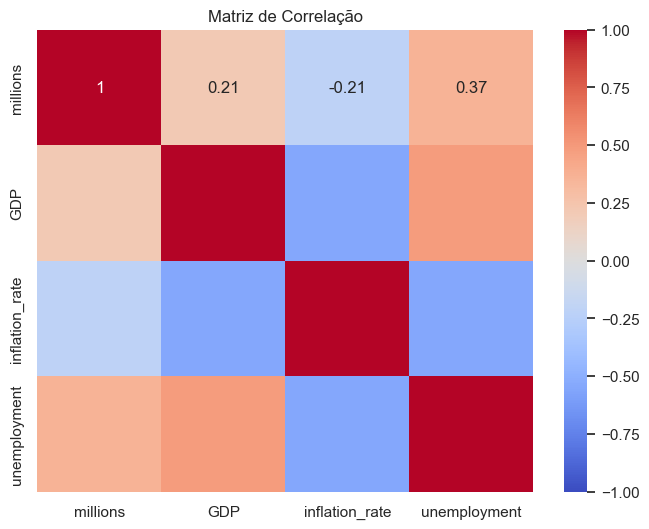

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de Correlação")
plt.show()

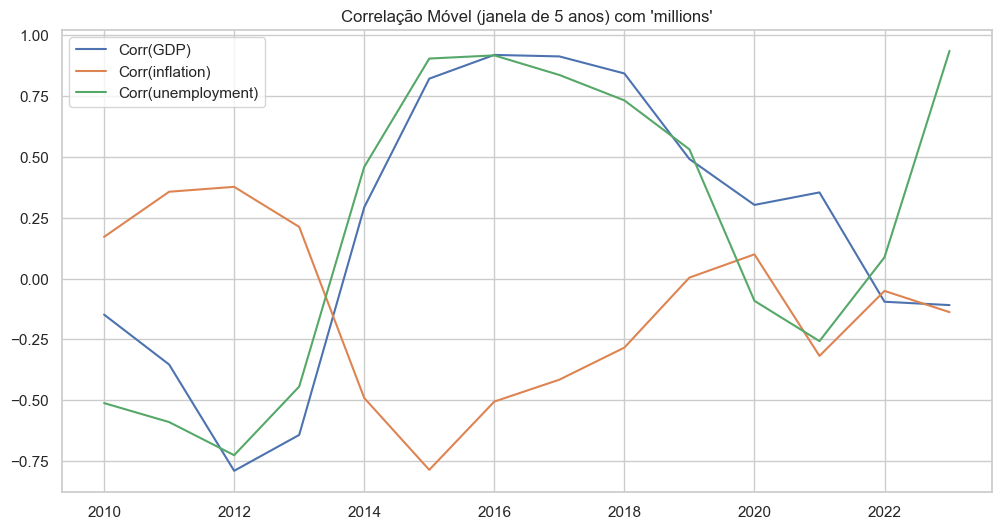

In [21]:
# Exemplo: correlação móvel em uma janela de 5 anos
merged_df['rolling_corr_GDP'] = merged_df['millions'].rolling(window=7).corr(merged_df['GDP'])
merged_df['rolling_corr_inflation'] = merged_df['millions'].rolling(window=7).corr(merged_df['inflation_rate'])
merged_df['rolling_corr_unemployment'] = merged_df['millions'].rolling(window=7).corr(merged_df['unemployment'])

# Plotar as correlações ao longo do tempo
plt.figure(figsize=(12, 6))
plt.plot(merged_df['year'], merged_df['rolling_corr_GDP'], label='Corr(GDP)')
plt.plot(merged_df['year'], merged_df['rolling_corr_inflation'], label='Corr(inflation)')
plt.plot(merged_df['year'], merged_df['rolling_corr_unemployment'], label='Corr(unemployment)')
plt.legend()
plt.title("Correlação Móvel (janela de 5 anos) com 'millions'")
plt.show()

<Figure size 1200x800 with 0 Axes>

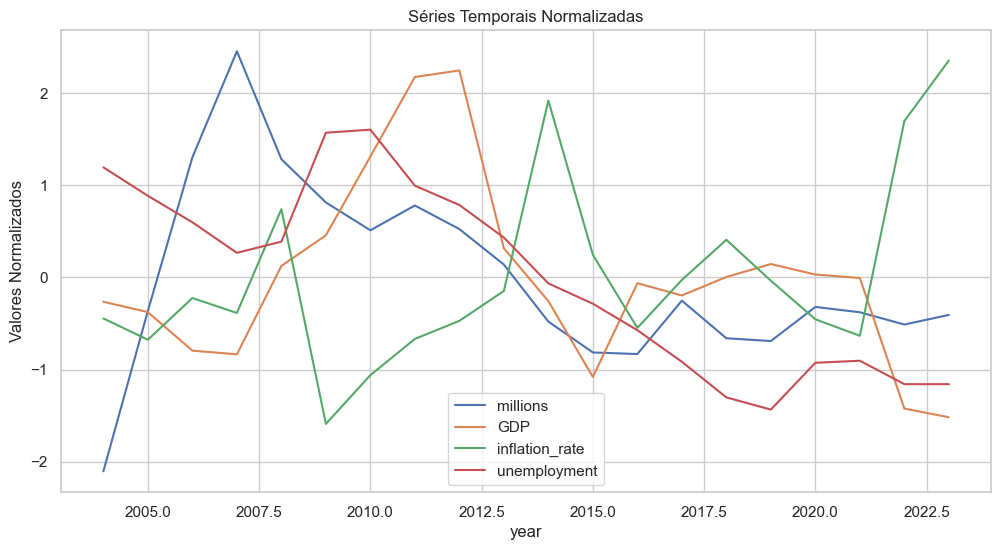

In [20]:
plt.figure(figsize=(12, 8))

# Normalizar as variáveis para plotar no mesmo gráfico (opcional)
normalized_df = (merged_df[['year', 'millions', 'GDP', 'inflation_rate', 'unemployment']]
                .set_index('year')
                .apply(lambda x: (x - x.mean()) / x.std()))

normalized_df.plot(figsize=(12, 6))
plt.title("Séries Temporais Normalizadas")
plt.ylabel("Valores Normalizados")
plt.show()

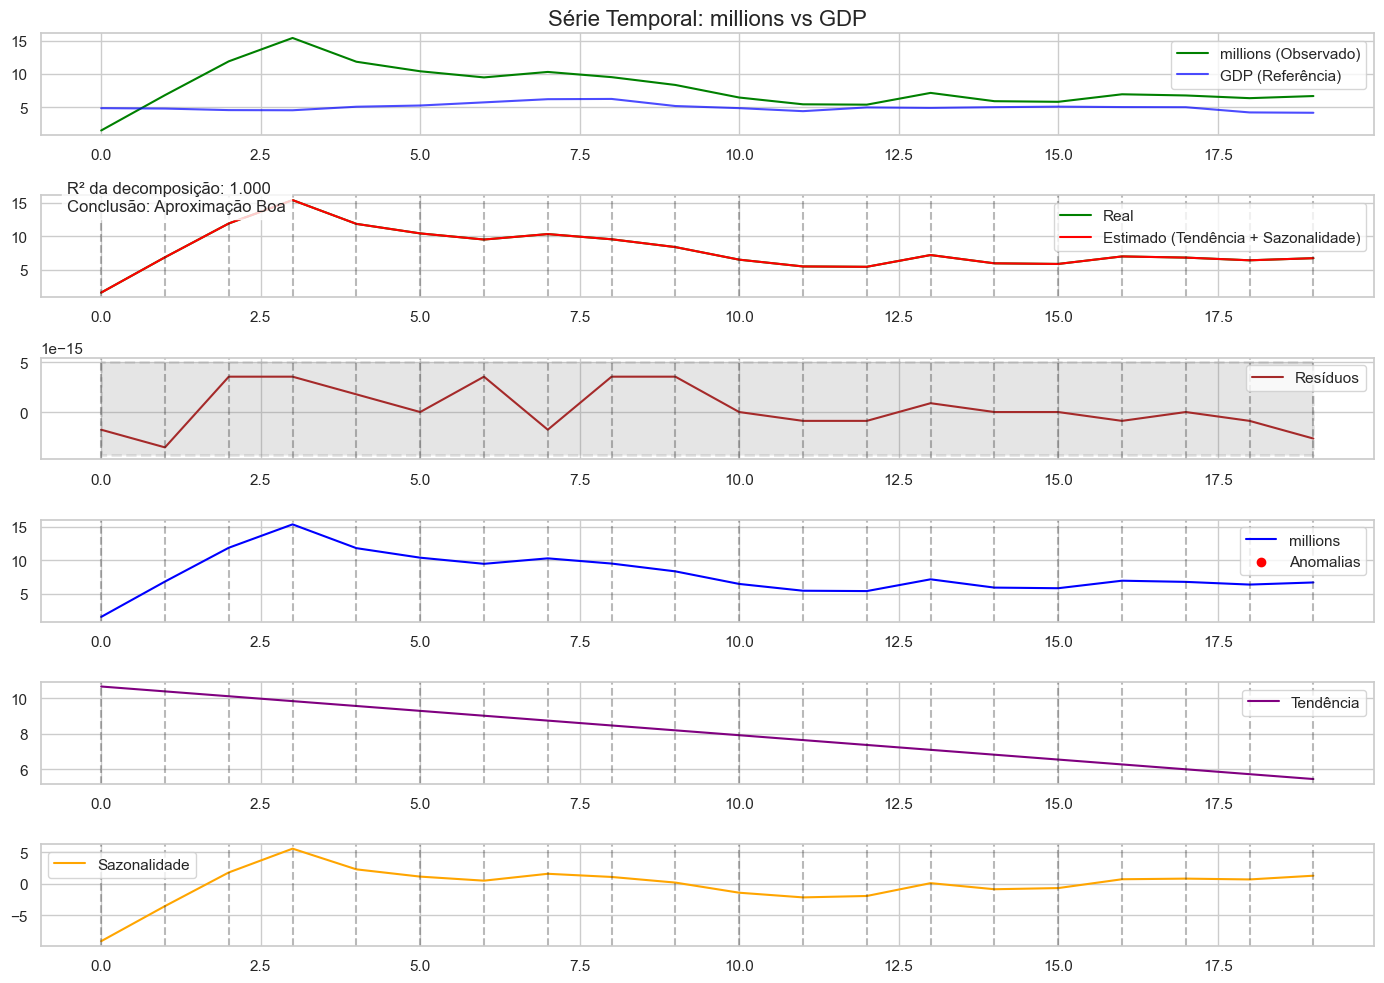

Correlação entre 'millions' e 'GDP': 0.214



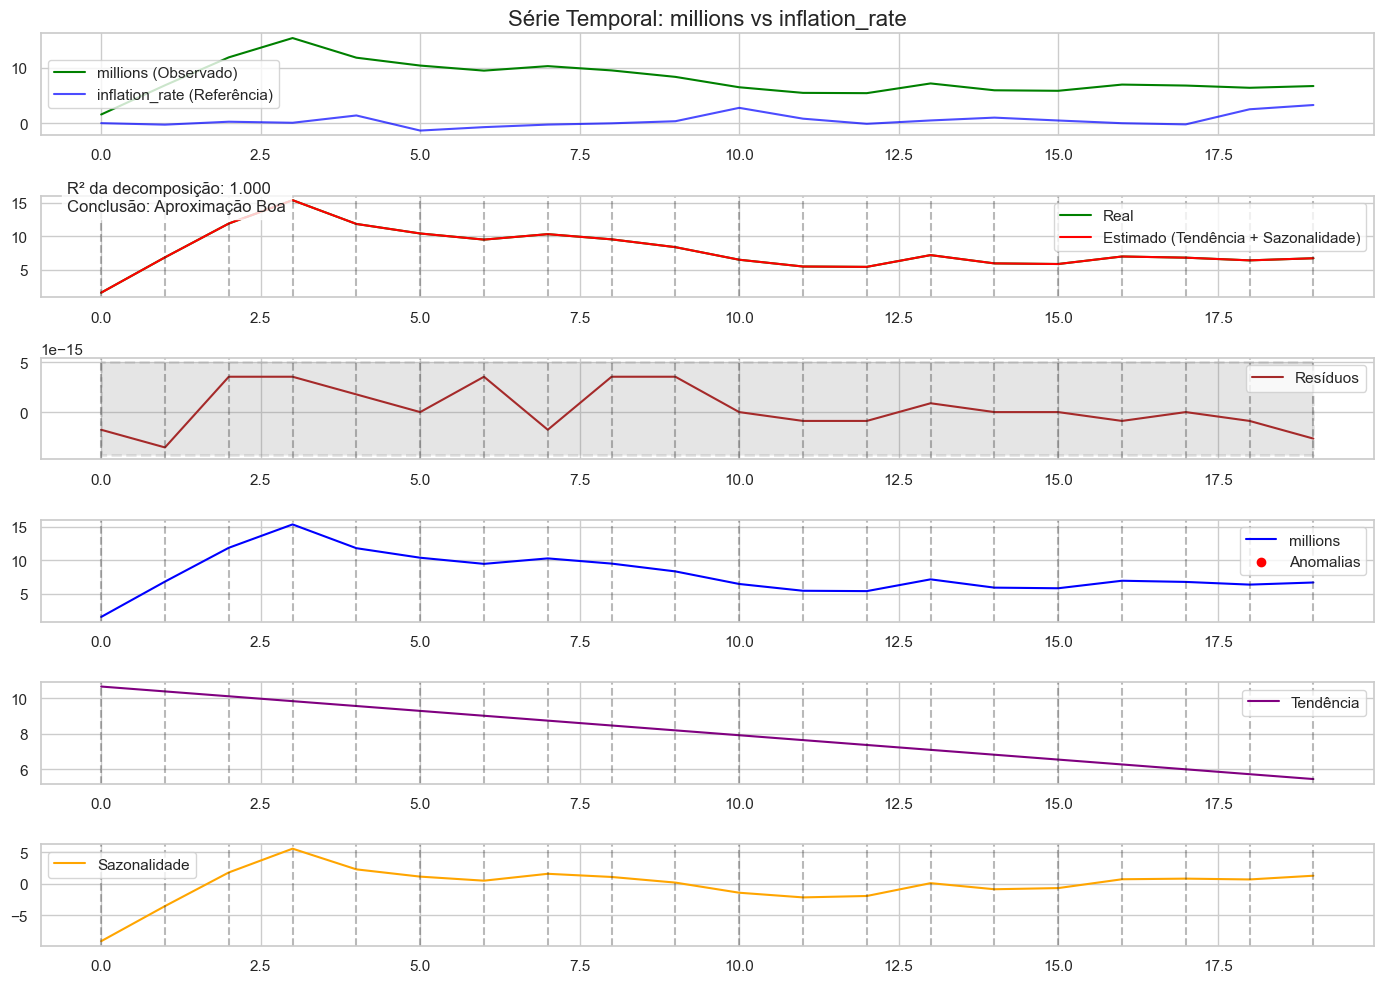

Correlação entre 'millions' e 'inflation_rate': -0.214



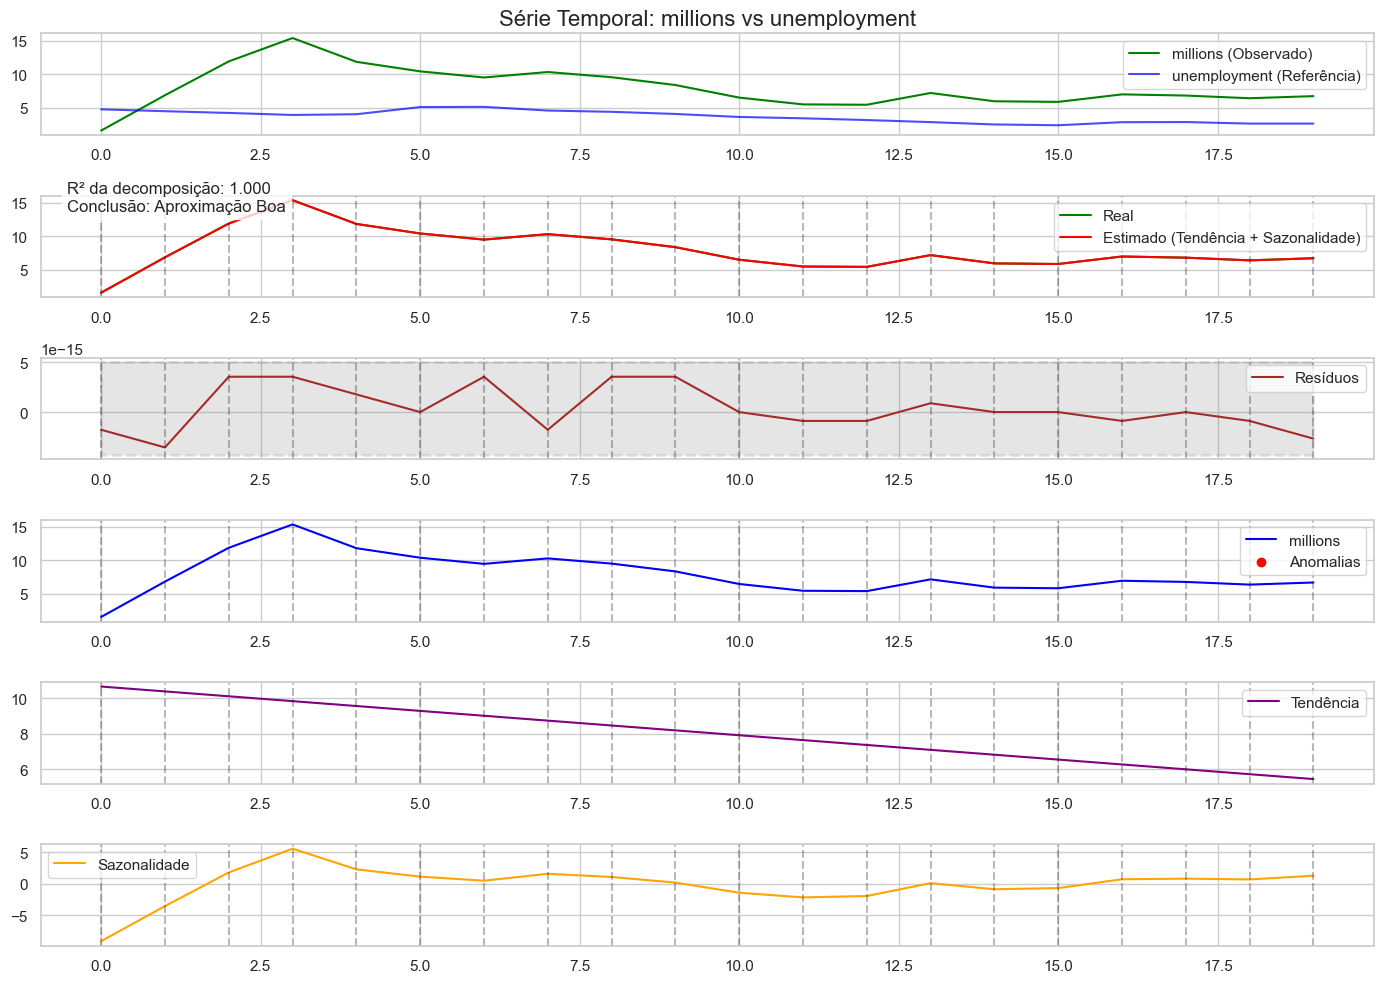

Correlação entre 'millions' e 'unemployment': 0.367



In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from datetime import datetime
import scipy.stats

# Supondo que seu DataFrame 'df' tenha uma coluna 'date' ou similar como índice temporal
# Caso não tenha, você pode criar assim:
# df['date'] = pd.to_datetime(df['year'], format='%Y')
# df.set_index('date', inplace=True)

# Variáveis a serem analisadas
variables = ['GDP', 'inflation_rate', 'unemployment']

for var in variables:
    # Seleciona a série 'millions' e a variável atual, removendo NAs e zeros
    actual_series = merged_df[['millions', var]].dropna()
    actual_series = actual_series[(actual_series['millions'] != 0) & (actual_series[var] != 0)]
    
    # Decomposição STL da série 'millions' (ajuste o período conforme seus dados)
    decomposition = STL(actual_series['millions'], period=12).fit()  # Periodo 12 para dados mensais
    
    date_min = actual_series.index.min()
    date_max = actual_series.index.max()
    
    plt.figure(figsize=(14, 10))
    
    # Série Observada (millions)
    plt.subplot(6, 1, 1)
    plt.title(f'Série Temporal: millions vs {var}', fontsize=16)
    plt.plot(actual_series['millions'], color='green', label='millions (Observado)')
    plt.plot(actual_series[var], color='blue', label=f'{var} (Referência)', alpha=0.7)
    plt.legend()
    
    # Série Estimada (Trend + Seasonal) e R²
    plt.subplot(6, 1, 2)
    ss_res = np.sum(decomposition.resid**2)
    ss_tot = np.sum((actual_series['millions'] - np.mean(actual_series['millions']))**2)
    r2 = 1 - (ss_res / ss_tot)
    
    text_test = (
        f'R² da decomposição: {r2:.3f}\n'
        f'Conclusão: {"Aproximação Insuficiente" if r2 < 0.8 else "Aproximação Boa"}'
    )
    plt.text(0.02, 0.85, text_test, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    estimated = decomposition.trend + decomposition.seasonal
    plt.plot(actual_series['millions'], color='green', label='Real')
    plt.plot(estimated, color='red', label='Estimado (Tendência + Sazonalidade)')
    for year in range(date_min, date_max + 1):
        plt.axvline(year, color='k', linestyle='--', alpha=0.3)
    plt.legend()
    
    # Resíduos com Intervalo de Confiança
    plt.subplot(6, 1, 3)
    resid = decomposition.resid
    resid_mu = resid.mean()
    resid_dev = resid.std()
    
    dist = scipy.stats.t(df=len(resid)-1)
    critical_value = dist.ppf(0.975)
    
    lower = resid_mu - (resid_dev * critical_value)
    upper = resid_mu + (resid_dev * critical_value)
    
    plt.plot(resid, color='brown', label='Resíduos')
    plt.fill_between(resid.index, lower, upper, color='gray', alpha=0.2, linestyle='--', linewidth=2)
    for year in range(date_min, date_max + 1):
        plt.axvline(year, color='k', linestyle='--', alpha=0.3)
    plt.legend()
    
    # Anomalias (pontos fora do intervalo de confiança)
    plt.subplot(6, 1, 4)
    anomalies = actual_series['millions'][(resid < lower) | (resid > upper)]
    plt.plot(actual_series['millions'], color='blue', label='millions')
    plt.scatter(anomalies.index, anomalies, color='red', marker='o', label='Anomalias')
    for year in range(date_min, date_max + 1):
        plt.axvline(year, color='k', linestyle='--', alpha=0.3)
    plt.legend()
    
    # Componente de Tendência
    plt.subplot(6, 1, 5)
    plt.plot(decomposition.trend, color='purple', label='Tendência')
    for year in range(date_min, date_max + 1):
        plt.axvline(year, color='k', linestyle='--', alpha=0.3)
    plt.legend()
    
    # Componente Sazonal
    plt.subplot(6, 1, 6)
    plt.plot(decomposition.seasonal, color='orange', label='Sazonalidade')
    for year in range(date_min, date_max + 1):
        plt.axvline(year, color='k', linestyle='--', alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Correlação entre 'millions' e a variável atual
    correlation = actual_series['millions'].corr(actual_series[var])
    print(f"Correlação entre 'millions' e '{var}': {correlation:.3f}\n")

In [30]:
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 6)

jp_sales_df['date'] = pd.to_datetime(jp_sales_df['week'])
jp_sales_df = jp_sales_df.set_index('date')
jp_trim_sales = jp_sales_df['sales'].resample('QE').sum()

jp_unemployment_df['date'] = pd.to_datetime(jp_unemployment_df['year'].astype(str) + '-12-31')
jp_unemployment_df = jp_unemployment_df.set_index('date')
jp_trim_unemployment = jp_unemployment_df['unemployment'].resample('QE').ffill()

concat = pd.concat([jp_trim_sales, jp_trim_unemployment], axis=1).dropna()
concat

,sales,unemployment
date,,
2004-12-31,1557436.0,4.73
2005-03-31,1460635.0,4.73
2005-06-30,909350.0,4.73
2005-09-30,1097567.0,4.73
2005-12-31,3371014.0,4.45
...,...,...
2023-12-31,1570550.0,2.60
2024-03-31,1255966.0,2.60
2024-06-30,999175.0,2.60


In [18]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name=''):
    """Executa e imprime os resultados do teste ADF."""
    print(f'--- Teste de Estacionariedade para {name} ---')
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Resultado: A série é estacionária.")
    else:
        print("Resultado: A série NÃO é estacionária. É necessário diferenciar.")
    print('-------------------------------------------\n')

In [31]:
adf_test(concat['sales'], 'Vendas')
adf_test(concat['unemployment'], 'PIB')

--- Teste de Estacionariedade para Vendas ---
ADF Statistic: -1.3624586209385192
p-value: 0.6001358146844281
Resultado: A série NÃO é estacionária. É necessário diferenciar.
-------------------------------------------

--- Teste de Estacionariedade para PIB ---
ADF Statistic: -0.9202342467491723
p-value: 0.7812359818907364
Resultado: A série NÃO é estacionária. É necessário diferenciar.
-------------------------------------------



In [33]:

# Se as séries não forem estacionárias, precisamos diferenciá-las.
# A diferenciação calcula a mudança de um período para o outro.
data_diff = concat.diff().dropna()

print("\n--- Testando novamente após a diferenciação ---")
adf_test(data_diff['sales'], 'Vendas Diferenciadas')
adf_test(data_diff['unemployment'], 'Desemprego Diferenciado')


--- Testando novamente após a diferenciação ---
--- Teste de Estacionariedade para Vendas Diferenciadas ---
ADF Statistic: -4.910792431867598
p-value: 3.322612050244053e-05
Resultado: A série é estacionária.
-------------------------------------------

--- Teste de Estacionariedade para Desemprego Diferenciado ---
ADF Statistic: -3.533697821132415
p-value: 0.007162681946352937
Resultado: A série é estacionária.
-------------------------------------------



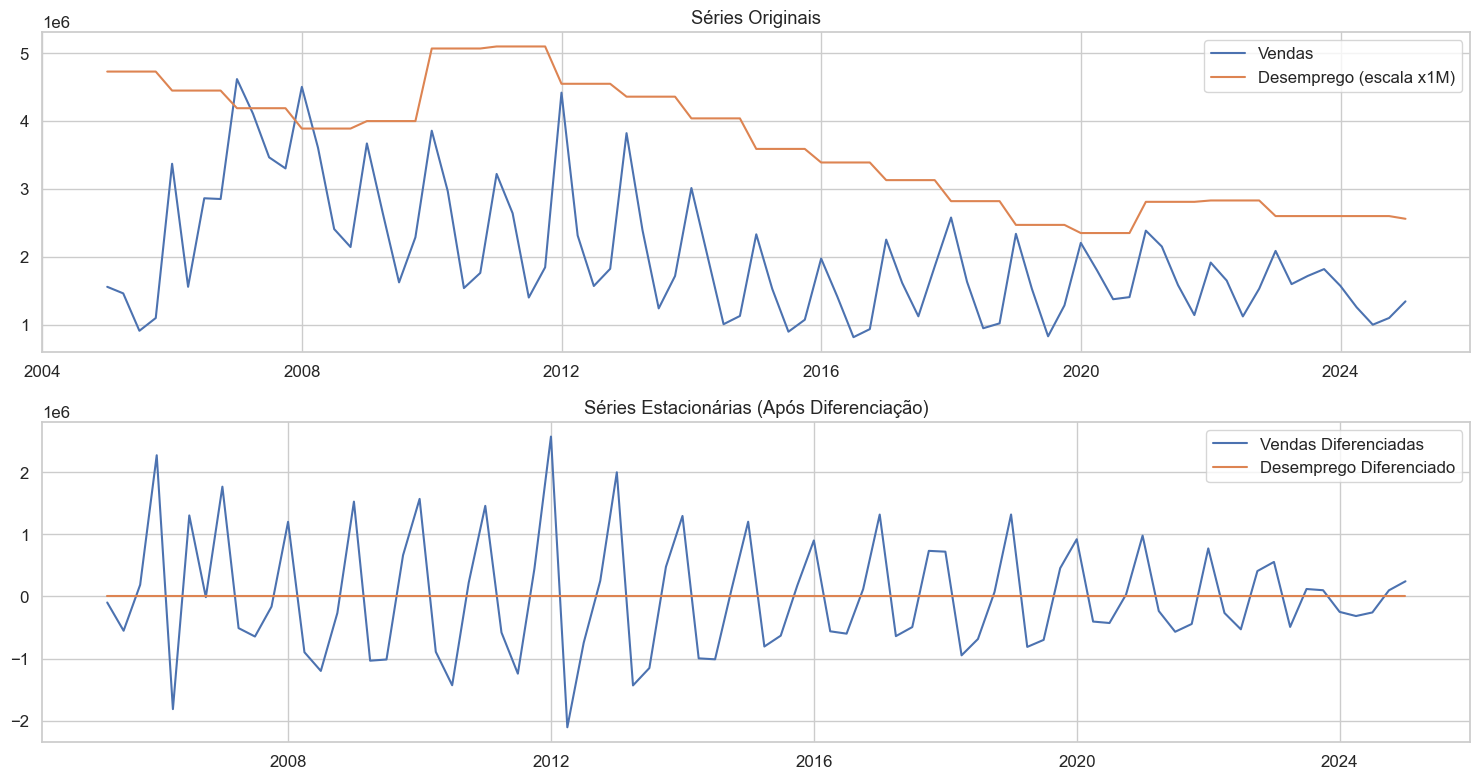

In [34]:

# Visualizando as séries
plt.figure(figsize=(15, 8))
plt.subplot(2,1,1)
plt.plot(concat['sales'], label='Vendas')
plt.plot(concat['unemployment']*1e6, label='Desemprego (escala x1M)') # Multiplicado para visualização
plt.title('Séries Originais')
plt.legend()

plt.subplot(2,1,2)
plt.plot(data_diff['sales'], label='Vendas Diferenciadas')
plt.plot(data_diff['unemployment'], label='Desemprego Diferenciado')
plt.title('Séries Estacionárias (Após Diferenciação)')
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
from statsmodels.tsa.stattools import grangercausalitytests
# Bloco 3: Executando e Interpretando o Teste de Causalidade de Granger
# ----------------------------------------------------------------------
# Agora que temos séries estacionárias, podemos rodar o teste.
# Vamos testar em ambas as direções:
# 1. Desemprego -> Vendas: Valores passados de desemprego ajudam a prever vendas futuras?
# 2. Vendas -> Desemprego: Valores passados de vendas ajudam a prever o desemprego futuro?

# O parâmetro `maxlag` define quantos períodos passados (trimestres) serão testados.
# Um valor comum para dados trimestrais é 4.
max_lags = 4
test_results = {}

print(f"\n--- Teste de Causalidade de Granger (maxlag={max_lags}) ---")

# Teste 1: Desemprego (causa) -> Vendas (efeito)
print("\nHipótese 1: Desemprego 'Granger-Causa' Vendas?")
print("H0: Valores passados de Desemprego NÃO explicam Vendas.")
gc_results_1 = grangercausalitytests(data_diff[['sales', 'unemployment']], maxlag=max_lags, verbose=True)
test_results['unemployment_->-sales'] = gc_results_1

print("\n" + "="*40 + "\n")

# Teste 2: Vendas (causa) -> Desemprego (efeito)
print("Hipótese 2: Vendas 'Granger-Causa' Desemprego?")
print("H0: Valores passados de Vendas NÃO explicam Desemprego.")
gc_results_2 = grangercausalitytests(data_diff[['unemployment', 'sales']], maxlag=max_lags, verbose=True)
test_results['sales_->-unemployment'] = gc_results_2


--- Teste de Causalidade de Granger (maxlag=4) ---

Hipótese 1: Desemprego 'Granger-Causa' Vendas?
H0: Valores passados de Desemprego NÃO explicam Vendas.

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2697  , p=0.1361  , df_denom=76, df_num=1
ssr based chi2 test:   chi2=2.3592  , p=0.1245  , df=1
likelihood ratio test: chi2=2.3247  , p=0.1273  , df=1
parameter F test:         F=2.2697  , p=0.1361  , df_denom=76, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3638  , p=0.2621  , df_denom=73, df_num=2
ssr based chi2 test:   chi2=2.9144  , p=0.2329  , df=2
likelihood ratio test: chi2=2.8613  , p=0.2392  , df=2
parameter F test:         F=1.3638  , p=0.2621  , df_denom=73, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5972  , p=0.6190  , df_denom=70, df_num=3
ssr based chi2 test:   chi2=1.9707  , p=0.5785  , df=3
likelihood ratio test: chi2=1.9459  , p=0.5837  , df=3
parameter F test

C:\Users\jpsmo\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jpsmo\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [36]:

# Bloco 4: Conclusão da Análise
# ---------------------------------
# Para interpretar, olhamos para o p-valor (coluna 'Pr(>F)').
# Se o p-valor para um determinado lag (atraso) for < 0.05, rejeitamos a Hipótese Nula (H0)
# para aquele lag e concluímos que há causalidade de Granger.

print("\n--- Resumo e Interpretação Final ---")

# Analisando resultados do Teste 1
p_values_1 = [round(test_results['unemployment_->-sales'][i+1][0]['ssr_ftest'][1], 4) for i in range(max_lags)]
significant_lags_1 = [i+1 for i, p in enumerate(p_values_1) if p < 0.05]

print("\nResultado para (Desemprego -> Vendas):")
if significant_lags_1:
    print(f"H0 é rejeitada. Evidência de causalidade encontrada nos lags (trimestres): {significant_lags_1}.")
    print("Isso sugere que mudanças na taxa de desemprego (e na confiança do consumidor) podem ser usadas para prever vendas futuras de consoles.")
else:
    print("H0 não pode ser rejeitada. Não há evidência estatística de que o desemprego Granger-causa as vendas.")


# Analisando resultados do Teste 2
p_values_2 = [round(test_results['sales_->-unemployment'][i+1][0]['ssr_ftest'][1], 4) for i in range(max_lags)]
significant_lags_2 = [i+1 for i, p in enumerate(p_values_2) if p < 0.05]

print("\nResultado para (Vendas -> Desemprego):")
if significant_lags_2:
    print(f"H0 é rejeitada. Evidência de causalidade encontrada nos lags (trimestres): {significant_lags_2}.")
    print("Isso sugere que o desempenho do mercado de consoles pode, de alguma forma, antecipar a saúde econômica futura.")
else:
    print("H0 não pode ser rejeitada. Não há evidência estatística de que as vendas Granger-causam o desemprego.")



--- Resumo e Interpretação Final ---

Resultado para (Desemprego -> Vendas):
H0 não pode ser rejeitada. Não há evidência estatística de que o desemprego Granger-causa as vendas.

Resultado para (Vendas -> Desemprego):
H0 não pode ser rejeitada. Não há evidência estatística de que as vendas Granger-causam o desemprego.


In [3]:
# Bloco 1: Configuração e Preparação dos Dados
# ------------------------------------------------
# Importamos as bibliotecas necessárias e preparamos os dados.
# O SARIMAX funciona melhor com dados de frequência constante, então agregaremos
# as vendas semanais para mensais. Os dados anuais de macroeconomia serão
# propagados para preencher os meses.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
# pmdarima ajuda a encontrar os melhores parâmetros (p,d,q) para o modelo ARIMA
import pmdarima as pm

In [9]:
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 6)

jp_sales_df['date'] = pd.to_datetime(jp_sales_df['week'])
jp_sales_df = jp_sales_df.set_index('date')
jp_month_sales = jp_sales_df['sales'].resample('ME').sum()

jp_unemployment_df['date'] = pd.to_datetime(jp_unemployment_df['year'].astype(str) + '-12-31')
jp_unemployment_df = jp_unemployment_df.set_index('date')
jp_month_unemployment = jp_unemployment_df['unemployment'].resample('ME').ffill()

jp_gdp_df['date'] = pd.to_datetime(jp_gdp_df['year'].astype(str) + '-12-31')
jp_gdp_df = jp_gdp_df.set_index('date')
jp_month_gdp = jp_gdp_df['GDP'].resample('ME').ffill()

concat = pd.concat([jp_month_sales, jp_month_gdp, jp_month_unemployment], axis=1).dropna()
concat

,sales,GDP,unemployment
date,,,
2004-11-30,0.0,4.519562,5.25
2004-12-31,1557436.0,4.893116,4.73
2005-01-31,832932.0,4.893116,4.73
2005-02-28,300419.0,4.893116,4.73
2005-03-31,327284.0,4.893116,4.73
...,...,...,...
2023-08-31,529875.0,4.256411,2.60
2023-09-30,620771.0,4.256411,2.60
2023-10-31,363115.0,4.256411,2.60



--- Iniciando Análise de Evento: Crise de 2008 ---
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=722.109, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=722.530, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=718.187, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=717.263, Time=0.02 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=718.124, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=720.542, Time=0.01 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=718.602, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 0.741 seconds

Melhores parâmetros encontrados para o período pré-200

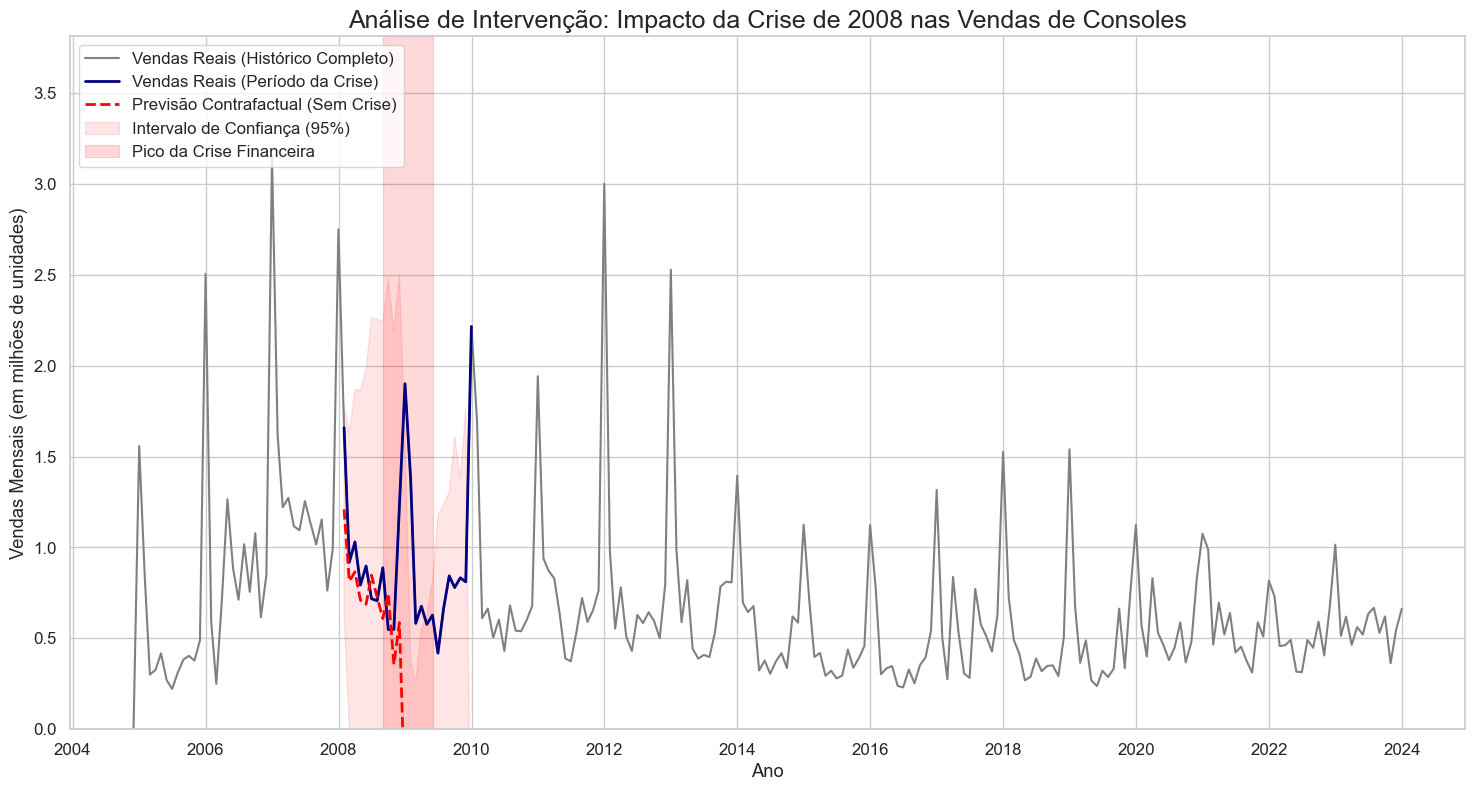

In [12]:
# Bloco 2: Análise de Evento - Crise Financeira de 2008
# --------------------------------------------------------
# Objetivo: Modelar o período pré-crise (2004-2007) para prever o
# comportamento das vendas durante a crise (2008-2009).

print("\n--- Iniciando Análise de Evento: Crise de 2008 ---")

# 1. Definir períodos e variáveis
train_2008 = concat.loc['2004-01-01':'2007-12-31']
test_2008 = concat.loc['2008-01-01':'2009-12-31']

# Variável endógena (o que queremos prever)
endog_2008 = train_2008['sales']
# Variáveis exógenas (usadas para ajudar na previsão)
exog_2008_train = train_2008[['GDP', 'unemployment']]
exog_2008_test = test_2008[['GDP', 'unemployment']]

# 2. Encontrar os melhores parâmetros SARIMAX com auto_arima
# `m=12` indica um ciclo sazonal anual (12 meses)
# CORREÇÃO: Removido d=1 e D=1 para permitir que auto_arima encontre os melhores
# parâmetros de diferenciação, resultando em um modelo mais estável.
auto_model_2008 = pm.auto_arima(endog_2008, exogenous=exog_2008_train,
                                start_p=1, start_q=1,
                                test='adf',
                                max_p=3, max_q=3, m=12,
                                start_P=0, seasonal=True,
                                max_d=2, max_D=1, trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)

print("\nMelhores parâmetros encontrados para o período pré-2008:")
print(auto_model_2008.summary())

# 3. Treinar o modelo final e prever
model_2008 = SARIMAX(endog_2008, exog=exog_2008_train, order=auto_model_2008.order, seasonal_order=auto_model_2008.seasonal_order)
results_2008 = model_2008.fit()
forecast_2008 = results_2008.get_forecast(steps=len(test_2008), exog=exog_2008_test)
forecast_mean_2008 = forecast_2008.predicted_mean
confidence_intervals_2008 = forecast_2008.conf_int()

# 4. Plotar os resultados
plt.figure(figsize=(18, 9))
plt.plot(concat['sales'] / 1e6, label='Vendas Reais (Histórico Completo)', color='gray') # Dividido por 1M para escala
plt.plot(test_2008['sales'] / 1e6, label='Vendas Reais (Período da Crise)', color='navy', lw=2)
plt.plot(forecast_mean_2008 / 1e6, label='Previsão Contrafactual (Sem Crise)', color='red', linestyle='--', lw=2)
plt.fill_between(confidence_intervals_2008.index,
                 confidence_intervals_2008.iloc[:, 0] / 1e6,
                 confidence_intervals_2008.iloc[:, 1] / 1e6, color='red', alpha=0.1, label='Intervalo de Confiança (95%)')

plt.title('Análise de Intervenção: Impacto da Crise de 2008 nas Vendas de Consoles', fontsize=18)
plt.xlabel('Ano')
plt.ylabel('Vendas Mensais (em milhões de unidades)') # Ajuste no label do eixo Y
plt.axvspan('2008-09-01', '2009-06-01', color='red', alpha=0.15, label='Pico da Crise Financeira')
plt.legend(loc='upper left')
plt.ylim(bottom=0) # Garante que o eixo Y não mostre valores negativos
plt.show()


--- Iniciando Análise de Evento: Pandemia de COVID-19 ---
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=2689.384, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2725.797, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2689.566, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2688.259, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2848.037, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=2715.396, Time=0.02 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=2686.501, Time=0.14 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=2698.942, Time=0.05 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=2683.999, Time=0.14 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=2683.044, Time=0.10 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=2689.932, Time=0.08 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=2683.789, Time=0.11 sec
 ARIMA(0,0,2)(0,0,2)[12] interce

C:\Users\jpsmo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


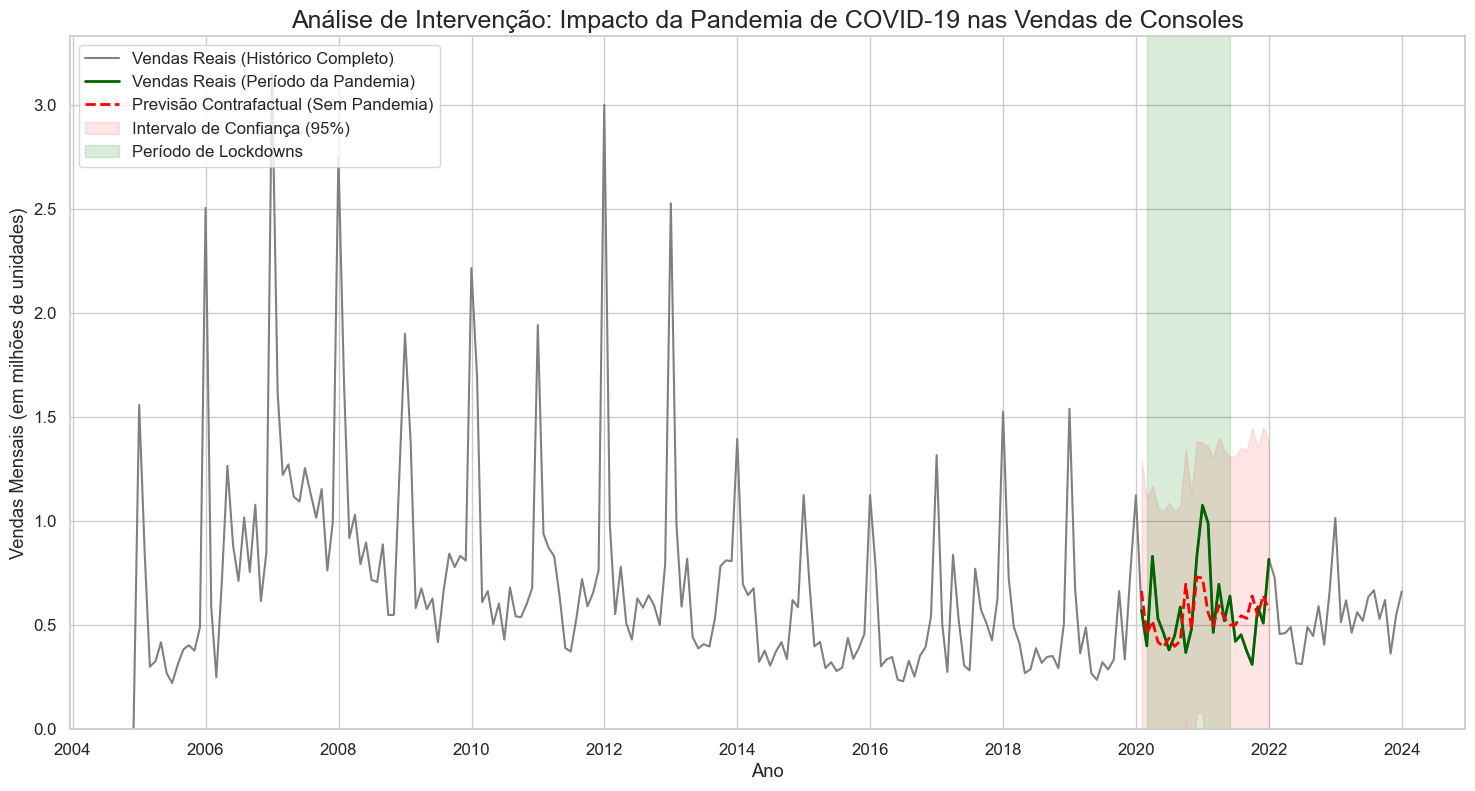

In [14]:

# Bloco 3: Análise de Evento - Pandemia de COVID-19
# ----------------------------------------------------
# Objetivo: Modelar o período pré-pandemia (2012-2019) para prever o
# comportamento das vendas durante a pandemia (2020-2021).

print("\n--- Iniciando Análise de Evento: Pandemia de COVID-19 ---")

# 1. Definir períodos e variáveis
train_2020 = concat.loc['2012-01-01':'2019-12-31']
test_2020 = concat.loc['2020-01-01':'2021-12-31']

endog_2020 = train_2020['sales']
exog_2020_train = train_2020[['GDP', 'unemployment']]
exog_2020_test = test_2020[['GDP', 'unemployment']]

# 2. Encontrar os melhores parâmetros SARIMAX
# CORREÇÃO: Aplicando a mesma lógica de deixar auto_arima encontrar os
# melhores parâmetros de diferenciação para consistência metodológica.
auto_model_2020 = pm.auto_arima(endog_2020, exogenous=exog_2020_train,
                                start_p=1, start_q=1,
                                test='adf',
                                max_p=3, max_q=3, m=12,
                                start_P=0, seasonal=True,
                                max_d=2, max_D=1, trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)

print("\nMelhores parâmetros encontrados para o período pré-2020:")
print(auto_model_2020.summary())

# 3. Treinar o modelo final e prever
model_2020 = SARIMAX(endog_2020, exog=exog_2020_train, order=auto_model_2020.order, seasonal_order=auto_model_2020.seasonal_order)
results_2020 = model_2020.fit()
forecast_2020 = results_2020.get_forecast(steps=len(test_2020), exog=exog_2020_test)
forecast_mean_2020 = forecast_2020.predicted_mean
confidence_intervals_2020 = forecast_2020.conf_int()

# 4. Plotar os resultados
plt.figure(figsize=(18, 9))
plt.plot(concat['sales'] / 1e6, label='Vendas Reais (Histórico Completo)', color='gray') # Dividido por 1M para escala
plt.plot(test_2020['sales'] / 1e6, label='Vendas Reais (Período da Pandemia)', color='darkgreen', lw=2)
plt.plot(forecast_mean_2020 / 1e6, label='Previsão Contrafactual (Sem Pandemia)', color='red', linestyle='--', lw=2)
plt.fill_between(confidence_intervals_2020.index,
                 confidence_intervals_2020.iloc[:, 0] / 1e6,
                 confidence_intervals_2020.iloc[:, 1] / 1e6, color='red', alpha=0.1, label='Intervalo de Confiança (95%)')

plt.title('Análise de Intervenção: Impacto da Pandemia de COVID-19 nas Vendas de Consoles', fontsize=18)
plt.xlabel('Ano')
plt.ylabel('Vendas Mensais (em milhões de unidades)') # Ajuste no label do eixo Y
plt.axvspan('2020-03-01', '2021-06-01', color='green', alpha=0.15, label='Período de Lockdowns')
plt.legend(loc='upper left')
plt.ylim(bottom=0) # Garante que o eixo Y não mostre valores negativos

# 5. Calcular e exibir o impacto total estimado
impact_df_2020 = pd.DataFrame({
    'vendas_reais': test_2020['sales'],
    'vendas_previstas': forecast_mean_2020
})
impact_df_2020['diferenca'] = impact_df_2020['vendas_reais'] - impact_df_2020['vendas_previstas']

vendas_reais_totais_2020 = impact_df_2020['vendas_reais'].sum()
vendas_previstas_totais_2020 = impact_df_2020['vendas_previstas'].sum()
impacto_total_2020 = impact_df_2020['diferenca'].sum()

print("\n--- Quantificação do Impacto da Pandemia (2020-2021) ---")
print(f"Vendas Reais Totais no período: {vendas_reais_totais_2020:,.0f} unidades.")
print(f"Vendas Previstas (Contrafactual) no período: {vendas_previstas_totais_2020:,.0f} unidades.")
print(f"Impacto Estimado (Diferença): {impacto_total_2020:,.0f} unidades vendidas a mais do que o esperado.")
if vendas_previstas_totais_2020 > 0:
    print(f"Isso representa um aumento de {(impacto_total_2020 / vendas_previstas_totais_2020) * 100:.2f}% em relação ao previsto.")

plt.show()

